In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Paths to your dataset
train_path = r"C:\Users\acess\OneDrive\Documents\Python Projects\Recipe_miniproject\splitted_data\train"
val_path = r"C:\Users\acess\OneDrive\Documents\Python Projects\Recipe_miniproject\splitted_data\val"
test_path = r"C:\Users\acess\OneDrive\Documents\Python Projects\Recipe_miniproject\splitted_data\test"

# Parameters
img_size = (224, 224)
batch_size = 32
num_classes = len(tf.io.gfile.listdir(train_path))

# Load datasets using image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Load VGG19 base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[:-8]:  # Unfreeze more layers
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replaces Flatten
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7),
    ModelCheckpoint(filepath="best_model.keras", monitor='val_accuracy', save_best_only=True)
]

# Model summary
model.summary()

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,  # Train for more epochs
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save("saved_models/vgg19_recipe_recognizer_optimized.keras")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 693 files belonging to 14 classes.
Found 195 files belonging to 14 classes.
Found 113 files belonging to 14 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,421,966 (77.90 MB)

 Trainable params: 14,556,430 (55.53 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.0635 - loss: 11.3008 - val_accuracy: 0.1795 - val_loss: 10.8685 - learning_rate: 5.0000e-05
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.0955 - loss: 10.8807 - val_accuracy: 0.2103 - val_loss: 10.6111 - learning_rate: 5.0000e-05
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.1177 - loss: 10.6012 - val_accuracy: 0.1846 - val_loss: 10.3435 - learning_rate: 5.0000e-05
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.1460 - loss: 10.3018 - val_accuracy: 0.2256 - val_loss: 9.9736 - learning_rate: 5.0000e-05
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step - accuracy: 0.2287 - loss: 10.0164 - val_accuracy: 0.1744 - val_loss: 10.0186 - learning_rate: 5.0000e-05
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.2234 - loss: 9.7915 - val_accuracy: 0.3487 - val_loss: 9.4406 - learning_rate: 5.0000e-05
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - a

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/vgg19_recipe_recognizer_optimized.keras'

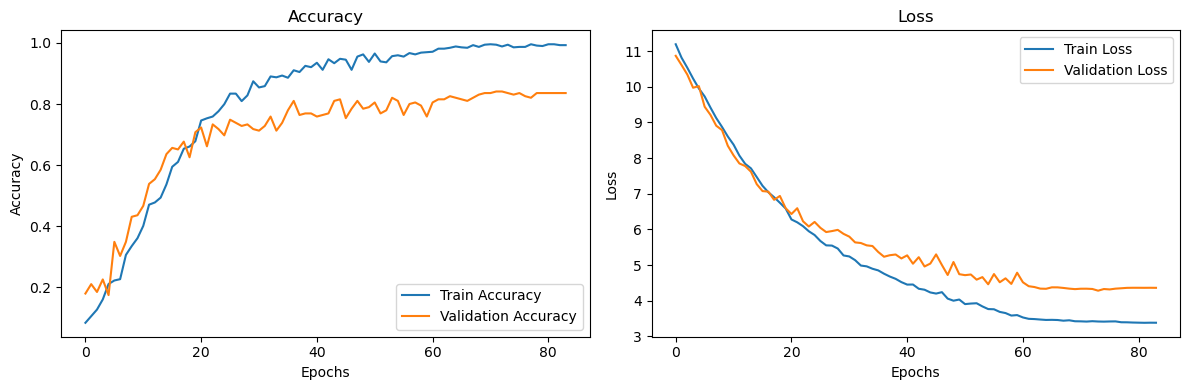

: 

In [ ]:
import os

# Create directory if it does not exist
os.makedirs("saved_models", exist_ok=True)

# Save the model
model.save("saved_models/vgg19_recipe_recognizer_optimized.h5")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
